In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable

from utils.process_img import Rescale, DynamicCrop, ToTensor, CenterCrop
from utils.func import weights_init, random_annotate, gaussian_noise
from pose_dataset import PoseDataset, print_sample
from model.generator import PoseGeneratorDC, PoseGeneratorL
from model.discriminator import PoseDiscriminatorDC, Discriminator, PoseDiscriminatorL
from utils.process_text import tokenizer, get_embeddings, get_word2idx

from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from collections import Counter

import torchvision.utils as vutils

In [22]:
# Parameters:
lr = 0.0002 
beta1 = 0.5 
img_size = 64
z_size = 16
batch_size = 3
composed = transforms.Compose([Rescale(512),
                               DynamicCrop(30),
                               Rescale((img_size, img_size))])

In [23]:
pose_dataset = PoseDataset('./data/data_list.csv', './data', transform = composed, gray_scale = True)
pose_dataloader = DataLoader(pose_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(len(pose_dataset))

8708


In [102]:
# Clustering on original image
X = []
for i in tqdm(range(len(pose_dataset))):
    sample = pose_dataset[i]
    img = sample['pose']
    flatten_img = np.reshape(img, (img.shape[0]**2))
    X.append(flatten_img)
X = np.array(X)

In [144]:
# with open('./intermediate/flatten_pose.pk', 'wb') as f:
#     pickle.dump(X, f)
# with open('./intermediate/features_mu.pk', 'rb') as f:
#     features_0 = pickle.load(f)
    
# with open('./intermediate/flatten_pose.pk', 'rb') as f:
#     feature_0 = pickle.load(f)

In [164]:
kmeans = KMeans(n_clusters=200, random_state=0, verbose=1, n_jobs=8)
kmeans.fit(features_0)
labels = kmeans.labels_

In [165]:
Counter(labels)

Counter({25: 31,
         177: 38,
         28: 31,
         131: 36,
         39: 76,
         186: 41,
         87: 41,
         123: 43,
         2: 83,
         42: 43,
         185: 32,
         171: 42,
         106: 45,
         82: 63,
         125: 30,
         158: 58,
         199: 44,
         45: 59,
         133: 45,
         41: 25,
         85: 43,
         121: 48,
         92: 42,
         10: 85,
         31: 68,
         8: 62,
         77: 33,
         127: 33,
         107: 38,
         155: 49,
         91: 50,
         47: 54,
         109: 28,
         67: 40,
         165: 21,
         118: 36,
         153: 49,
         105: 45,
         189: 51,
         0: 43,
         188: 36,
         136: 49,
         66: 87,
         70: 85,
         27: 40,
         26: 38,
         68: 29,
         29: 44,
         15: 36,
         142: 25,
         112: 58,
         166: 39,
         140: 52,
         174: 28,
         115: 68,
         53: 94,
         170: 40,
    

In [181]:
# Creating sample group:
label2imgs = {}
for i in tqdm(range(len(labels))):
    img = pose_dataset[i]['pose']
    label2imgs[labels[i]] = label2imgs.get(labels[i], []) + [img]

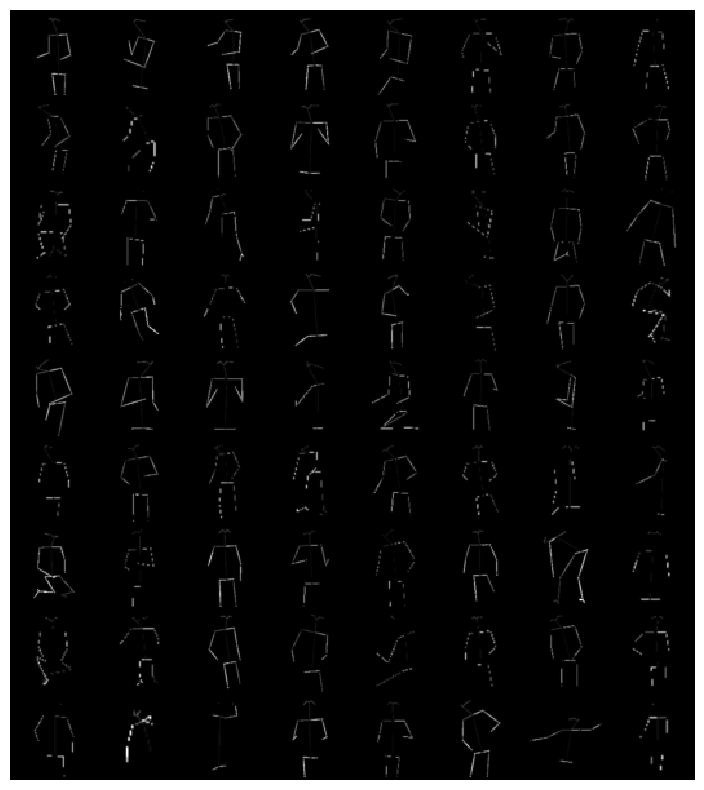

In [238]:
class_id = 20
imgs = label2imgs[class_id]
imgs_t = torch.from_numpy(np.array(imgs))
imgs_t = torch.reshape(imgs_t, [-1, 1, 64, 64])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(imgs_t, padding=2, normalize=True).cpu(),(1,2,0)))
#plt.savefig('pure_class.png', dpi=512)
plt.show()

In [193]:
annotates = [' '.join(a) for a in pose_dataset.annotations]
annotate2count = {}
for i in tqdm(range(len(labels))):
    if labels[i] == 2:
        annotate2count[annotates[i]] = annotate2count.get(annotates[i], 0) + 1
sorted(annotate2count.items(), key = lambda x:x[1])[::-1]

[('rope skipping general', 29),
 ('aerobic step', 5),
 ('jogging', 3),
 ('running', 3),
 ('elliptical trainer moderate effort', 2),
 ('trimming shrubs or trees', 2),
 ('general dancing e.g. disco folk irish step dancing line dancing polka contra country',
  1),
 ('carpentry general workshop taylor code 620', 1),
 ('resistance training', 1),
 ('walking the dog', 1),
 ('swimming general', 1),
 ('tennis hitting balls non-game play moderate effort', 1),
 ('farming rice planting grain milling activities', 1),
 ('rollerblading', 1),
 ('making bed changing linens', 1),
 ('walking general', 1),
 ('clearing brush', 1),
 ('ballet modern or jazz', 1),
 ('walking applying fertilizer or seeding a lawn push applicator', 1),
 ('loading unloading a car implied walking', 1),
 ('fishing in stream in waders taylor code 670', 1),
 ('juggling', 1),
 ('gardening general moderate effort', 1),
 ('running cross country', 1),
 ('standing talking in church', 1),
 ('jai alai', 1),
 ('snow shoeing', 1),
 ('sweepin

<Figure size 12800x12800 with 0 Axes>

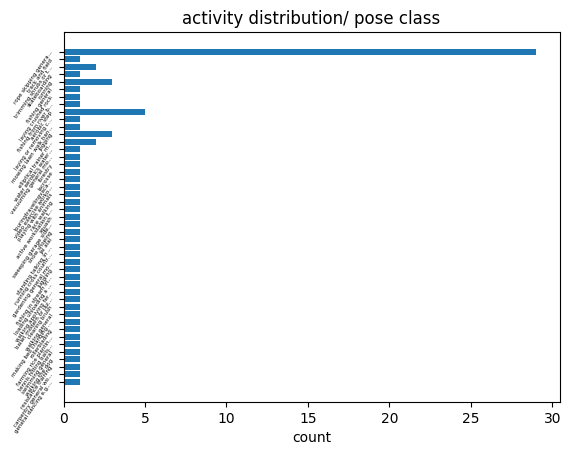

In [229]:
#plt.rcdefaults()
plt.figure(figsize=(128, 128))
fig, ax = plt.subplots()

# Example data
annos = list(annotate2count.keys())
annos = [a[:20]+(len(a)>20)*'...' for a in annos]
y_pos = np.arange(len(annos))
counts = list(annotate2count.values())

ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(annos, rotation=55, fontsize=4)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('count')
ax.set_title('activity distribution/ pose class')

plt.savefig('activity_distribution.png', dpi=512)
plt.show()
